## Transfer Learning
For many applied problems, there are no large labeled datasets.
A common trick is training on a similar but large dataset and completing updating the weights using the small target dataset.

This technique is called ** Transfer Learning **

In convolution networks  for classification, there are two parts:
- the body of the network is a set of convolutions and poolings
- the head is MLP (a set of fully connected layers) after which softmax is applied and the probabilities of different classes are obtained.


A computationally simple tranfer learning option is to retrain the head network.


We need a [pre-trained model] (http://pytorch.org/docs/master/torchvision/datasets.html#torchvision-datasets) and a dataset for our task.

We will transfer ImageNet to the dataset https://download.pytorch.org/tutorial/hymenoptera_data.zip


The dataset contains pictures of two classes (`ants` and` bees`) of different sizes.

In [25]:
# On a windows machine, you need to download and unzip by yourself
#! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
#! unzip ./hymenoptera_data.zip

The data loader is one of the important components for the effective training of neural networks:
Asynchronous loading and fast preprocessing are important for full GPU utilization.

We recommend that you familiarize yourself with and use [Pytorch Dataset] (http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)

Usage example:

In [26]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import warnings

warnings.filterwarnings("ignore")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'C:\Users\Abhishek\Desktop\hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
plt.ion()

In [27]:
# for Google Colab uncomment this:
# !pip install pillow==4.1.1
# %reload_ext autoreload
# %autoreload

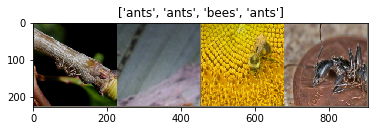

In [28]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [29]:
# we save the best weights thus far
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).type(torch.float)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [30]:
# torchvision has many models with pre-trained weigts:
[m for m in dir(models) if not m.startswith('_')]

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'Inception3',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 'alexnet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'video']

In [31]:
# Loading the pretrained model
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

params_to_train = model_ft.parameters()

# use GPU if you have it
if use_gpu:
    model_ft = model_ft.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer_ft = optim.SGD(params_to_train, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [32]:
# Training the model to do evaluations
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
# Best val Acc: 0.941176

Epoch 0/24
----------
train Loss: 0.1596 Acc: 0.7008
val Loss: 0.0695 Acc: 0.8889
Elapsed 2m 11s

Epoch 1/24
----------
train Loss: 0.1654 Acc: 0.7623
val Loss: 0.0561 Acc: 0.9281
Elapsed 4m 18s

Epoch 2/24
----------
train Loss: 0.1494 Acc: 0.7623
val Loss: 0.1495 Acc: 0.7647
Elapsed 6m 30s

Epoch 3/24
----------
train Loss: 0.1152 Acc: 0.8074
val Loss: 0.0688 Acc: 0.9216
Elapsed 8m 43s

Epoch 4/24
----------
train Loss: 0.1278 Acc: 0.8033
val Loss: 0.0666 Acc: 0.9085
Elapsed 10m 59s

Epoch 5/24
----------
train Loss: 0.0797 Acc: 0.8730
val Loss: 0.0814 Acc: 0.9020
Elapsed 13m 22s

Epoch 6/24
----------
train Loss: 0.0741 Acc: 0.8852
val Loss: 0.0695 Acc: 0.9216
Elapsed 15m 41s

Epoch 7/24
----------
train Loss: 0.0736 Acc: 0.8730
val Loss: 0.0599 Acc: 0.9281
Elapsed 18m 2s

Epoch 8/24
----------
train Loss: 0.0798 Acc: 0.8730
val Loss: 0.0670 Acc: 0.9281
Elapsed 20m 29s

Epoch 9/24
----------
train Loss: 0.0674 Acc: 0.9098
val Loss: 0.0632 Acc: 0.9281
Elapsed 22m 52s

Epoch 10/24
---

In [33]:
# Loading the pretrained model
model_conv = torchvision.models.resnet18(pretrained=True)

for params in model_conv.parameters():
    params.requires_grad = False 

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

params_to_train = model_conv.fc.parameters()

# use GPU if you have it
if use_gpu:
    model_conv = model_conv.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer_conv = optim.SGD(params_to_train, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [34]:
# Training the model to do evaluations
model_conv = train_model(
    model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)
# Best val Acc: 0.967320
# We get better predictions when we just retrain the last layer and not the whole model reason being transfer learning.

Epoch 0/24
----------
train Loss: 0.1497 Acc: 0.7008
val Loss: 0.0616 Acc: 0.9216
Elapsed 1m 15s

Epoch 1/24
----------
train Loss: 0.1445 Acc: 0.7664
val Loss: 0.0730 Acc: 0.8824
Elapsed 2m 33s

Epoch 2/24
----------
train Loss: 0.1322 Acc: 0.7869
val Loss: 0.0658 Acc: 0.9020
Elapsed 3m 55s

Epoch 3/24
----------
train Loss: 0.1012 Acc: 0.8320
val Loss: 0.0446 Acc: 0.9477
Elapsed 5m 47s

Epoch 4/24
----------
train Loss: 0.0978 Acc: 0.8320
val Loss: 0.0947 Acc: 0.8693
Elapsed 7m 26s

Epoch 5/24
----------
train Loss: 0.1099 Acc: 0.8525
val Loss: 0.0517 Acc: 0.9412
Elapsed 8m 58s

Epoch 6/24
----------
train Loss: 0.0752 Acc: 0.8484
val Loss: 0.0416 Acc: 0.9477
Elapsed 10m 31s

Epoch 7/24
----------
train Loss: 0.0914 Acc: 0.8402
val Loss: 0.0431 Acc: 0.9542
Elapsed 12m 7s

Epoch 8/24
----------
train Loss: 0.0882 Acc: 0.8320
val Loss: 0.0418 Acc: 0.9542
Elapsed 13m 45s

Epoch 9/24
----------
train Loss: 0.0886 Acc: 0.8484
val Loss: 0.0414 Acc: 0.9608
Elapsed 15m 15s

Epoch 10/24
-----

In [35]:
#Generalized function to visualize the model predictions on few examples from the validation set
def visualize(model, num_images=10):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, label = data
        if use_gpu:
            inputs, label = Variable(inputs.cuda()), Variable(label.cuda())
        else:
            inputs, label = Variable(inputs), Variable(label)

        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[pred[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

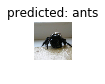

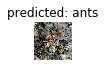

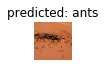

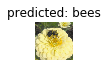

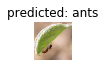

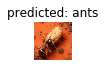

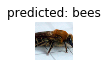

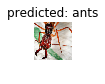

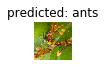

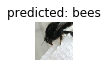

In [36]:
# Making predictions 
visualize(model_ft)
plt.ioff()
plt.show()

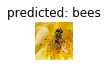

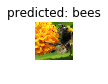

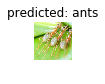

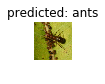

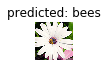

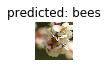

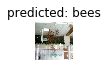

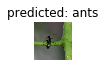

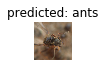

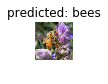

In [37]:
# Making predictions 
visualize(model_conv)
plt.ioff()
plt.show()